# Aggregate Profitability Analysis

This notebook uses the data from my thesis (without any filtering) to see if the aggregate profitability of public firms relates with macroeconomic aggregate measures like GDP, GVA, Corporate Profits, and more...

## Importing

### Importing Relevant Packages

In [41]:
import numpy as np
import pandas as pd
import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from statsmodels.regression.rolling import RollingOLS

# to access Macro data
def FRED(code):
    fred_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id='
    df = pd.read_csv(fred_url + code)
    if 'DATE' in df.columns:
        df['DATE'] = df.apply(lambda row: datetime.date.fromisoformat(row.DATE), axis=1)
        df['DATE'] = pd.to_datetime(df['DATE'])
        df.set_index('DATE', inplace=True)
    time.sleep(2)  # So that I don't get blocked through excessive requests
    return df

# to calculate percent differences correctly
def pct_diff(series: pd.Series, periods: int = 1) -> pd.Series:
    """
    Calculate the percent difference of a pandas series.

    Parameters
    ----------
    series : pandas.Series
        Input series to calculate percent difference from.
    periods : int, default=1
        Number of periods to shift the series by.

    Returns
    -------
    pandas.Series
        Series with percent difference from the shifted series.

    """
    shifted_series = series.shift(periods)
    rs = series / shifted_series.where(shifted_series >= 0, np.nan) - 1
    return rs

# to quickly make a correlation matrix heatmap
def correlmap(data):
    data_correlation = data.corr()    
    sns.heatmap(data_correlation, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
    plt.show()
    display(pd.DataFrame(data_correlation.sum(), columns=['Sum of Correlations']))


def cqtr_to_date(cqtr, end=False):
    # cqtr is string
    stryear = cqtr[:4]
    quarter = int(cqtr[-1:])
    if end:
        month = quarter * 3
        strmonth = str(month)
        days = '30' if quarter == 2 or quarter == 3 else 31
        strdays = str(days)
    else:
        month = quarter * 3 - 2
        strmonth = str(month)
        strdays = '01'
    if len(strmonth) == 1:
            strmonth = '0' + strmonth
    return np.datetime64(stryear + '-' + strmonth + '-' + strdays)



from scipy.stats import pearsonr

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues


In [2]:
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['font.family'] = 'NewComputerModern10Book'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['ytick.left'] = False

def comma(x, pos):
    return f'{x:,.0f}'

#plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

### Importing Calculated Data

In [3]:
tdfs = pd.read_csv('../Data/regressions_results_2024-03-20.csv', 
                   dtype={
                       'gvkey': np.unicode_,
                       'datadate': np.unicode_,
                       'fyearq': 'float32',
                       'fqtr': 'float32',
                       'indfmt': np.unicode_,
                       'consol': np.unicode_,
                       'popsrc': np.unicode_,
                       'datafmt': np.unicode_,
                       'tic': np.unicode_,
                       'cusip': np.unicode_,
                       'conm': np.unicode_,
                       'curcdq': np.unicode_,
                       'datacqtr': np.unicode_,
                       'datafqtr': np.unicode_,
                       'naics': np.unicode_,
                       'sic': np.unicode_,
                       'ggroup': np.unicode_,
                       'gind': np.unicode_,
                       'gsector': np.unicode_,
                       'gsubind': np.unicode_,
                       'cik': np.unicode_,
                       'costat': np.unicode_,
                       'actq': 'float64',
                       'atq': 'float64',
                       'ceqq': 'float64',
                       'chq': 'float64',
                       'cshfdq': 'float64',
                       'cshoq': 'float64',
                       'cshprq': 'float64',
                       'dlcq': 'float64',
                       'dlttq': 'float64',
                       'dpactq': 'float64',
                       'dpq': 'float64',
                       'icaptq': 'float64',
                       'lctq': 'float64',
                       'niq': 'float64',
                       'oiadpq': 'float64',
                       'oibdpq': 'float64',
                       'piq': 'float64',
                       'revtq': 'float64',
                       'teqq': 'float64',
                       'txtq': 'float64',
                       'xintq': 'float64',
                       'xrdq': 'float64',
                       'dvy': 'float64',
                       'cik': 'float64',
                       'mktvalq': 'float64',
                       'prccq': 'float64', 
                       'tid': np.unicode_,
                       'qid': np.unicode_,
                       'beta': np.float64,
                       'beta_se': np.float64,
                       'alpha': np.float64,
                       'alpha_se': np.float64,
                       'r2': np.float64,
                       'DGS1': np.float64,
                       'rfr': np.float64,
                       'Market_Cap': np.float64,
                       'Cash': np.float64,
                       'Debt': np.float64,
                       'Net_Debt': np.float64,
                       'Long_Term_Debt': np.float64,
                       'Enterprise_Value': np.float64,
                       'Current_Assets': np.float64,
                       'Current_Liabilities': np.float64,
                       'Current_Liabilities_minus_ST_Debt': np.float64,
                       'Current_Ratio': np.float64,
                       'Common_Equity': np.float64,
                       'NI': np.float64,
                       'Pretax_Income': np.float64,
                       'EBIT': np.float64,
                       'EBITDA': np.float64,
                       'Taxes': np.float64,
                       'Tax_Rate': np.float64,
                       'Revenue': np.float64,
                       'NOPAT': np.float64,
                       'Total_Costs': np.float64,
                       'Total_Costs_inc_t': np.float64,
                       'RnD': np.float64,
                       'Assets': np.float64,
                       'Invested_Capital': np.float64,
                       'tobins_q': np.float64,
                       'EBIT_margin': np.float64,
                       'ROIC': np.float64,
                       'ROA': np.float64,
                       'ROE': np.float64,
                       'beta_ul': np.float64,
                       'RR': np.float64,
                       'qRR': np.float64,
                       'RRIC': np.float64,
                       'RREV': np.float64,
                       'Excess_Profit': np.float64,
                       'Total_Costs_inc_RRIC': np.float64,
                       'Total_Costs_inc_RREV': np.float64,
                       'Market_Cap_Growth': np.float64,
                       'Enterprise_Value_Growth': np.float64,
                       'EBIT_Growth': np.float64,
                       'Revenue_Growth': np.float64,
                       'Total_Costs_Growth': np.float64,
                       'Total_Costs_inc_t_Growth': np.float64,
                       'Assets_Growth': np.float64,
                       'Invested_Capital_Growth': np.float64,
                       'tobins_q_Growth': np.float64,
                       'ROIC_Growth': np.float64,
                       'ROA_Growth': np.float64,
                       'RRIC_Growth': np.float64,
                       'RREV_Growth': np.float64,
                       'Excess_Profit_Growth': np.float64,
                       'Total_Costs_inc_RRIC_Growth': np.float64,
                       'naics1': np.unicode_,
                       'naics2': np.unicode_,
                       'naics3': np.unicode_,
                       'naics4': np.unicode_,
                       'naics5': np.unicode_,
                       'naics6': np.unicode_,
                       'mktshare1': np.float64,
                       'mktshare2': np.float64,
                       'mktshare3': np.float64,
                       'mktshare4': np.float64,
                       'mktshare5': np.float64,
                       'mktshare6': np.float64,
                       'hhi1': np.float64,
                       'hhi2': np.float64,
                       'hhi3': np.float64,
                       'hhi4': np.float64,
                       'hhi5': np.float64,
                       'hhi6': np.float64,
                       'tobins_q_agg': np.float64,
                       'ROIC_agg': np.float64,
                       'ROA_agg': np.float64,
                       'RR_agg': np.float64,
                       '?': np.float64,
                       'price_cost_margin': np.float64,
                       'price_cost_margin_se': np.float64,
                       'price_cost_margin_na': np.float64,
                       'lerner': np.float64,
                       'lerner_se': np.float64,
                       'lerner_na': np.float64,
                       'mroic': np.float64,
                       'mroic_se': np.float64,
                       'mroic_na': np.float64,
                       'ar_coef': np.float64,
                       'ar_coef_se': np.float64,
                       'ar_int': np.float64,
                       'ar_int_se': np.float64,
                       'ar_na': np.float64
                   }, index_col=0
                  )
tdfs['datadate'] = pd.to_datetime(tdfs.datadate)
tdfs['cyear'] = tdfs.datadate.apply(lambda row: row.year)

tdfs['hhi_gsubind'] = tdfs['hhi_gsubind'].apply(lambda hhi: hhi if hhi < 1 else 1)
tdfs['mktshare_gsubind'] = tdfs['mktshare_gsubind'].apply(lambda ms: ms if ms < 1 else 1)

List of current public firms
(have a beta from 2Q23)

In [4]:
current_public_gvkeys = tdfs[tdfs.datacqtr == '2023Q2'][['beta','gvkey']].dropna().gvkey.unique()
print('Total dataframe:', tdfs.gvkey.nunique(), 'firms;', len(tdfs), 'observations')
print('Currently public:', len(current_public_gvkeys), 'firms;', len(tdfs[tdfs.gvkey.isin(current_public_gvkeys)]))

Total dataframe: 28721 firms; 1432601 observations
Currently public: 4106 firms; 399976


## Data Transformation

### Aggregation Columns

In [5]:
agg_cols = ['Revenue', 'EBIT', 'EBITDA', 'NI', 'Assets', 'Debt', 'Enterprise_Value', 'Cash']
agg_cols_names = {col:col for col in agg_cols}
agg_cols_names['Enterprise_Value'] = 'EV'

### Naive Aggregation

Observations: 1307925 ;   Firms: 27438


,Revenue,EBIT,EBITDA,NI,Assets,Debt,Enterprise_Value,Cash,datacqtr
datacqtr,,,,,,,,,
2012-01-01,6269109.890,7.494230e+05,9.862185e+05,403893.134,5.437446e+07,1.831452e+07,3.576565e+07,2834515.867,2012Q1
2012-04-01,6587204.321,8.851982e+05,1.168777e+06,420594.903,5.827151e+07,1.872943e+07,3.679653e+07,2949006.732,2012Q2
2012-07-01,6234716.439,7.453551e+05,9.997312e+05,359408.007,5.499458e+07,1.833301e+07,3.573609e+07,2788496.987,2012Q3
2012-10-01,7384801.318,8.370801e+05,1.161356e+06,397749.559,6.095137e+07,2.005602e+07,4.038266e+07,3074817.769,2012Q4
2013-01-01,6167587.841,7.469187e+05,1.006357e+06,494436.535,5.371662e+07,1.829214e+07,3.755014e+07,2741922.328,2013Q1
2013-04-01,6792162.208,8.833918e+05,1.200636e+06,483036.051,5.989605e+07,1.884168e+07,4.036221e+07,2940634.114,2013Q2
2013-07-01,6383681.273,7.854059e+05,1.068689e+06,492503.790,5.546997e+07,1.802277e+07,3.932599e+07,2906289.736,2013Q3
2013-10-01,7380438.137,8.921326e+05,1.232669e+06,426612.614,6.169140e+07,1.995589e+07,4.641917e+07,3235187.712,2013Q4
2014-01-01,6464599.777,7.625387e+05,1.035673e+06,476688.478,5.661920e+07,1.810875e+07,4.152143e+07,2921859.157,2014Q1


,Revenue,EBIT,EBITDA,NI,Assets,Debt,Enterprise_Value,Cash
count,4.400000e+01,4.400000e+01,4.400000e+01,44.000000,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01
mean,6.805698e+06,8.269068e+05,1.165048e+06,453653.007614,6.327459e+07,2.097495e+07,5.255167e+07,3.529364e+06
std,8.234483e+05,1.719461e+05,1.955943e+05,162375.002685,7.241456e+06,2.526140e+06,1.228398e+07,7.687787e+05
min,5.532499e+06,4.123182e+05,7.677407e+05,-30537.031000,5.371662e+07,1.802277e+07,3.573609e+07,2.741922e+06
25%,6.245432e+06,7.434959e+05,1.025361e+06,377035.065500,5.718348e+07,1.884956e+07,4.349973e+07,2.941420e+06
50%,6.495425e+06,7.990156e+05,1.140362e+06,441801.098000,6.172032e+07,2.011477e+07,4.914166e+07,3.189689e+06
75%,7.360136e+06,9.229573e+05,1.283148e+06,530869.790750,6.725638e+07,2.239275e+07,5.924557e+07,3.999202e+06
max,9.233123e+06,1.222454e+06,1.625859e+06,856378.754000,8.005299e+07,2.669767e+07,8.502401e+07,5.263494e+06


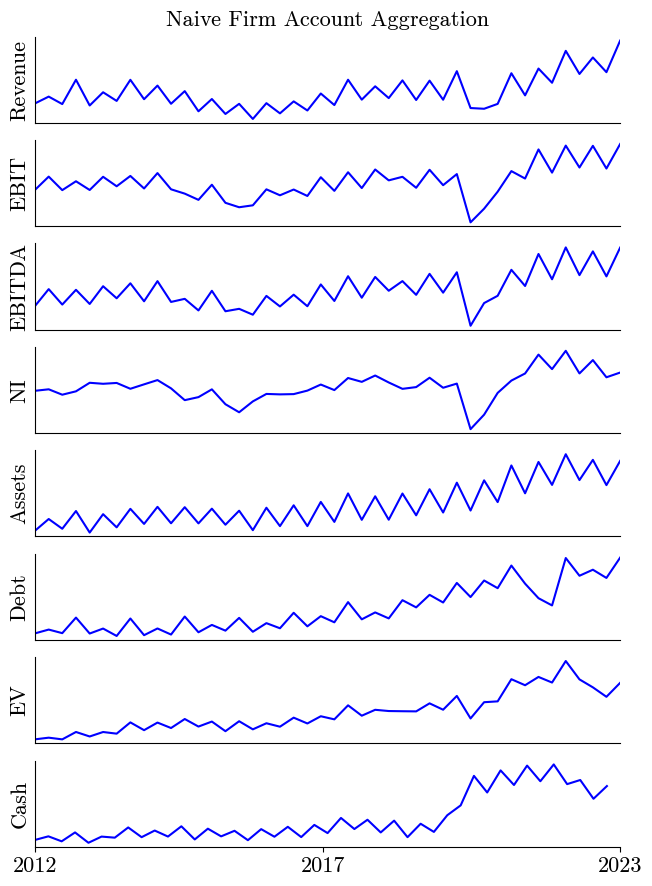

In [69]:
print('Observations:', len(tdfs[tdfs.Revenue > 0]), ';   Firms:', tdfs[tdfs.Revenue > 0].gvkey.nunique())

naive_agg = tdfs.groupby('datacqtr')[agg_cols].sum()
naive_agg = naive_agg[(naive_agg.index > '2011Q4') & (naive_agg.index < '2023Q1')]
naive_agg['datacqtr'] = naive_agg.index
naive_agg.index = naive_agg.datacqtr.apply(lambda x: cqtr_to_date(x, end=False))

display(naive_agg)
display(naive_agg.describe())

fig, ax = plt.subplots(len(naive_agg.columns[:-1]), figsize=(6.5, 9))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.suptitle('Naive Firm Account Aggregation', fontsize=16)
for i, col in enumerate(naive_agg.columns[:-1]):
    ax[i].plot(naive_agg[col], color='blue')
    ax[i].set_xlim(naive_agg.index.min(), naive_agg.index.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel(agg_cols_names[col])
    if i == len(naive_agg.columns) - 2:
        ax[i].set_xticks([np.datetime64('2012-01-01'), np.datetime64('2017-06-01'), np.datetime64('2022-12-31')])
        ax[i].set_xticklabels(['2012', 2017, '2023'])
    else:
        ax[i].set_xticks([])
plt.savefig('Aggregates_time_series.svg')
plt.show()

### Refined Aggregation

Most basic filtering

- Reports non-zero revenue for all quarters where it is observed (drops all observations before that date for that firm if not true)
- Reports EBIT and net income for the same periods that they report Revenue
- Only examines ~2012 to ~2022

Observations: 70664 ;   Firms: 1606


,Revenue,EBIT,EBITDA,NI,Assets,Debt,Enterprise_Value,Cash,datacqtr
datacqtr,,,,,,,,,
2012-01-01,3000828.253,404274.4360,555941.2130,222810.558,2.391743e+07,8.910738e+06,2.065711e+07,1322505.197,2012Q1
2012-04-01,2997281.677,394678.4240,548903.4980,197773.558,2.380877e+07,8.857540e+06,1.981346e+07,1317987.028,2012Q2
2012-07-01,3065214.431,401142.8970,565041.3660,190664.537,2.422461e+07,8.948787e+06,2.058808e+07,1330814.412,2012Q3
2012-10-01,3102128.318,329162.2740,498445.7030,166571.337,2.414802e+07,8.836274e+06,2.048925e+07,1317098.195,2012Q4
2013-01-01,2963739.820,394822.8020,553746.3560,294373.924,2.428048e+07,8.885129e+06,2.141512e+07,1299972.321,2013Q1
2013-04-01,3039796.287,383818.2760,547639.5800,210956.410,2.413311e+07,8.871034e+06,2.150603e+07,1293710.411,2013Q2
2013-07-01,3113972.736,410514.5750,580027.7130,237991.326,2.448369e+07,8.977622e+06,2.216100e+07,1418960.842,2013Q3
2013-10-01,3151683.994,390117.5290,562696.1520,212771.093,2.459045e+07,9.012340e+06,2.336126e+07,1403411.081,2013Q4
2014-01-01,3124465.467,401848.2970,574042.6070,223950.609,2.475872e+07,9.112882e+06,2.377110e+07,1365178.972,2014Q1


,Revenue,EBIT,EBITDA,NI,Assets,Debt,Enterprise_Value,Cash
count,4.400000e+01,44.000000,44.000000,44.000000,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01
mean,3.269377e+06,423642.541966,622673.094966,242107.412659,2.794899e+07,1.090843e+07,2.939566e+07,1.682511e+06
std,4.304505e+05,95669.262968,111576.047147,90290.251428,3.719305e+06,1.770170e+06,7.230435e+06,3.731347e+05
min,2.722125e+06,234451.783000,460870.106000,16392.891000,2.380877e+07,8.836274e+06,1.981346e+07,1.293710e+06
25%,2.994192e+06,369901.545000,546916.239750,192810.609500,2.477059e+07,9.290698e+06,2.420588e+07,1.404972e+06
50%,3.128911e+06,408966.405000,583034.046500,224654.265500,2.675026e+07,1.054271e+07,2.789628e+07,1.549896e+06
75%,3.440973e+06,462541.084500,682391.319250,289023.593250,3.081142e+07,1.265936e+07,3.308572e+07,2.011320e+06
max,4.509848e+06,653900.239000,903966.936000,456039.472000,3.492917e+07,1.375120e+07,4.543825e+07,2.406604e+06


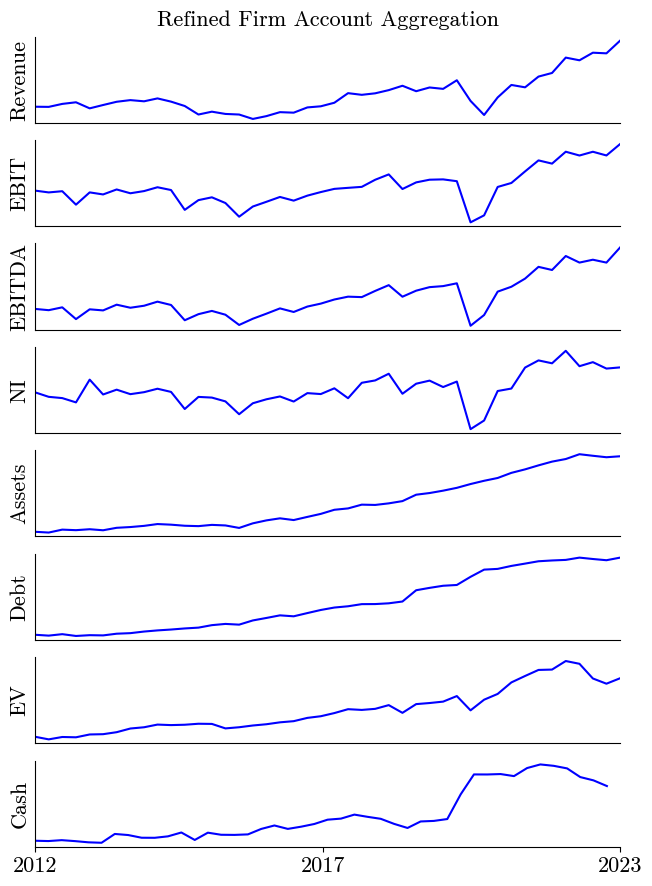

In [70]:
rdf = tdfs[(tdfs.datacqtr > '2011Q4') & (tdfs.datacqtr < '2023Q1')].copy().dropna(subset=agg_cols).copy()
rdf = pd.merge(rdf, rdf[agg_cols + ['gvkey']].groupby('gvkey').count().min(axis=1).rename('valid_vals'), left_on='gvkey', right_index=True)
rdf = rdf[rdf.valid_vals >= rdf.valid_vals.max()]

print('Observations:', len(rdf), ';   Firms:', rdf.gvkey.nunique())

rdf = rdf.groupby('datacqtr')[agg_cols].sum()
rdf = rdf[(rdf.index > '2011Q4') & (rdf.index < '2023Q1')]
rdf['datacqtr'] = rdf.index
rdf.index = rdf.datacqtr.apply(lambda x: cqtr_to_date(x, end=False))

display(rdf)
display(rdf.describe())

fig, ax = plt.subplots(len(rdf.columns[:-1]), figsize=(6.5, 9))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.suptitle('Refined Firm Account Aggregation', fontsize=16)
for i, col in enumerate(rdf.columns[:-1]):
    ax[i].plot(rdf[col], color='blue')
    ax[i].set_xlim(rdf.index.min(), rdf.index.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel(agg_cols_names[col])
    if i == len(rdf.columns) - 2:
        ax[i].set_xticks([np.datetime64('2012-01-01'), np.datetime64('2017-06-01'), np.datetime64('2022-12-31')])
        ax[i].set_xticklabels(['2012', 2017, '2023'])
    else:
        ax[i].set_xticks([])
plt.savefig('Aggregates_time_series_refined.svg')
plt.show()

### National Income Accounts

ALL for **non-financial corporate businesses** (except for those notated with *)

- Nominal GDP*: `NGDPSAXDCUSQ`
- Debt: `TCMILBSNNCB`
- Debt as % of market value: `NCBCMDPMVCE`
- Profits Before Tax (without IVA and CCAdj): `BOGZ1FU106060005Q`
- Profits Before Tax with IVA and CCAdj: `BOGZ1FU106060035Q`
- Total Assets: `TABSNNCB`
- Total Liabilities: `TLBSNNCB`
- Interest Paid (transactions): `BOGZ1FU106130001Q`
- Total CapEx (transactions): `BOGZ1FU105050005Q`
- Gross Value Added of Nonfinancial Corporate Businesses: `BOGZ1FU106902501Q`
- Net Value Added of Nonfinancial Corporate Businesses: `BOGZ1FU106902605Q`
- Revenue, Excluding Indirect Sales Taxes, (transactions): `BOGZ1FU106030005Q`
- Earnings Before Interest and Tax: `BOGZ1FU106110115Q`
- Retained Earnings: `BOGZ1FU106110405Q`
- Taxes on Corporate Income: `BOGZ1FU106231005Q`


<br/>

Use the following URL and add filters as needed: 

https://fred.stlouisfed.org/searchresults/?st=nonfinancial&t=nsa%3Bnonfinancial%3Bquarterly%3Btax&rt=tax&ob=sr

In [15]:
fdf = FRED('NGDPSAXDCUSQ')

fred_cols = {
    'NGDP': 'NGDPSAXDCUSQ',
    'Debt': 'TCMILBSNNCB',
    'Debt_as_pct_of_mkt_val': 'NCBCMDPMVCE',
    'Profitspretax_NOIVACC': 'BOGZ1FU106060005Q', 
    'Profits_pretax_IVACC': 'BOGZ1FU106060035Q',
    'Assets': 'TABSNNCB',
    'Liabilities': 'TLBSNNCB',
    'Interest_Exp': 'BOGZ1FU106130001Q',
    'CapEx': 'BOGZ1FU105050005Q',
    'GVA': 'BOGZ1FU106902501Q',
    'NVA': 'BOGZ1FU106902605Q',
    'Revenue': 'BOGZ1FU106030005Q',
    'EBIT': 'BOGZ1FU106110115Q',
    'Retained_Earnings': 'BOGZ1FU106110405Q',
    'Income_Taxes': 'BOGZ1FU106231005Q'
}

for col in list(fred_cols.keys())[1:]:
    fdf = pd.merge(fdf, FRED(fred_cols[col]), left_index=True, right_index=True, how='outer')

fdf.columns = list(fred_cols.keys())

fdf = fdf.replace('.', np.nan)
fdf = fdf.astype('float64')

display(fdf)
display(fdf.describe())

,NGDPSAXDCUSQ,TCMILBSNNCB,NCBCMDPMVCE,BOGZ1FU106060005Q,BOGZ1FU106060035Q,TABSNNCB,TLBSNNCB,BOGZ1FU106130001Q,BOGZ1FU105050005Q,BOGZ1FU106902501Q,BOGZ1FU106902605Q,BOGZ1FU106030005Q,BOGZ1FU106110115Q,BOGZ1FU106110405Q,BOGZ1FU106231005Q
DATE,,,,,,,,,,,,,,,
1945-10-01,NaN,44.653,42.575823,NaN,NaN,286.179,87.067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-10-01,NaN,49.889,50.660527,22603.0,23843.0,311.970,99.374,1568.0,19182.0,100771.0,93019.0,100771.0,17972.0,3050.0,8573.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,6602101.3,13439.307,26.482664,583413.0,1150021.0,57551.206,26730.841,108023.0,630038.0,3387843.0,2870268.0,3387843.0,753515.0,236431.0,104450.0
2023-01-01,6703400.3,13633.558,24.932633,593479.0,1136240.0,58425.661,26824.723,108023.0,709599.0,3423298.0,2892906.0,3423298.0,696680.0,210289.0,109359.0
2023-04-01,6765753.0,13668.064,23.165347,605514.0,1144789.0,59462.313,26977.134,108023.0,640532.0,3460327.0,2922062.0,3460327.0,715140.0,225181.0,107591.0


,NGDPSAXDCUSQ,TCMILBSNNCB,NCBCMDPMVCE,BOGZ1FU106060005Q,BOGZ1FU106060035Q,TABSNNCB,TLBSNNCB,BOGZ1FU106130001Q,BOGZ1FU105050005Q,BOGZ1FU106902501Q,BOGZ1FU106902605Q,BOGZ1FU106030005Q,BOGZ1FU106110115Q,BOGZ1FU106110405Q,BOGZ1FU106231005Q
count,2.960000e+02,295.000000,295.000000,294.000000,2.940000e+02,295.000000,295.000000,294.000000,294.000000,2.930000e+02,2.930000e+02,2.930000e+02,294.000000,294.00000,294.000000
mean,1.859702e+06,3328.871644,48.281491,126698.037415,2.930471e+05,14833.476512,7048.273749,59275.996599,183164.816327,9.497371e+05,8.137249e+05,9.497371e+05,204327.173469,60337.64966,29356.105442
std,1.851813e+06,3686.562318,18.898358,148251.264035,3.068094e+05,16011.048070,7639.514560,50110.923844,185042.277835,9.143874e+05,7.722776e+05,9.143875e+05,200207.483528,64275.11389,25118.284513
min,7.020700e+04,44.653000,19.512041,7227.000000,1.154700e+04,286.179000,87.067000,636.000000,5387.000000,4.535100e+04,4.149200e+04,4.535100e+04,7991.000000,1847.00000,3508.000000
25%,2.366762e+05,281.467000,34.124067,19258.250000,3.603525e+04,1304.133000,765.933000,4470.000000,23295.250000,1.400200e+05,1.264750e+05,1.400200e+05,26371.250000,9019.50000,7990.500000
50%,1.172473e+06,1920.462000,41.905264,56855.000000,1.732990e+05,8754.638000,3819.062000,60318.000000,116690.000000,6.382390e+05,5.563370e+05,6.382390e+05,136383.500000,32412.50000,21357.000000
75%,3.244413e+06,5402.907000,63.743898,190881.750000,4.951048e+05,26731.095500,11465.993000,108023.000000,293171.750000,1.634086e+06,1.407863e+06,1.634086e+06,341106.500000,94661.00000,44164.750000
max,6.984708e+06,13689.088000,99.215468,653755.000000,1.164973e+06,59751.311000,27320.312000,153181.000000,770028.000000,3.510409e+06,2.966046e+06,3.510410e+06,753515.000000,256834.00000,110318.000000


In [25]:
fdf = fdf[fdf.index.isin(naive_agg.index)].copy()
fdf.describe()

,NGDP,Debt,Debt_as_pct_of_mkt_val,Profitspretax_NOIVACC,Profits_pretax_IVACC,Assets,Liabilities,Interest_Exp,CapEx,GVA,NVA,Revenue,EBIT,Retained_Earnings,Income_Taxes
count,4.400000e+01,44.000000,44.000000,44.000000,4.400000e+01,44.000000,44.000000,44.000000,44.000000,4.400000e+01,4.400000e+01,4.400000e+01,44.000000,44.000000,44.000000
mean,5.006678e+06,9777.937023,28.151931,381111.431818,8.324754e+05,42253.134500,20754.345886,118396.181818,505284.340909,2.514912e+06,2.127857e+06,2.514912e+06,534622.795455,168081.272727,65763.272727
std,7.083759e+05,2020.588927,3.872656,103612.920329,1.334863e+05,8707.044985,3562.102416,12490.771074,82164.052879,3.811959e+05,3.247134e+05,3.811959e+05,85598.816806,29354.605543,15440.920381
min,4.017201e+06,6774.962000,19.512041,292100.000000,6.729540e+05,29559.709000,15088.642000,106762.000000,368804.000000,2.003017e+06,1.699511e+06,2.003017e+06,338741.000000,100758.000000,44210.000000
25%,4.471279e+06,8102.621500,26.533395,323510.000000,7.510532e+05,35406.114250,17690.905750,108023.000000,440501.250000,2.266847e+06,1.923330e+06,2.266847e+06,485635.250000,151265.250000,54287.750000
50%,4.891405e+06,9371.367000,28.110166,335283.500000,7.779065e+05,41343.975000,20318.786000,114381.000000,501474.000000,2.415895e+06,2.043484e+06,2.415895e+06,512264.000000,163841.000000,64517.000000
75%,5.424335e+06,11727.185750,30.609401,365820.500000,8.743180e+05,48449.920750,24386.571500,125402.000000,547877.500000,2.706911e+06,2.281628e+06,2.706911e+06,546584.000000,185081.250000,72947.750000
max,6.602101e+06,13439.307000,35.869843,653755.000000,1.150021e+06,57679.123000,26730.841000,148472.000000,770028.000000,3.387843e+06,2.870284e+06,3.387843e+06,753515.000000,236431.000000,106117.000000


In [39]:
rmdf = pd.merge(rdf[rdf.columns[:-1]].pct_change().add_suffix('_WRDS'), fdf.pct_change().add_suffix('_MACRO'), left_index=True, right_index=True)

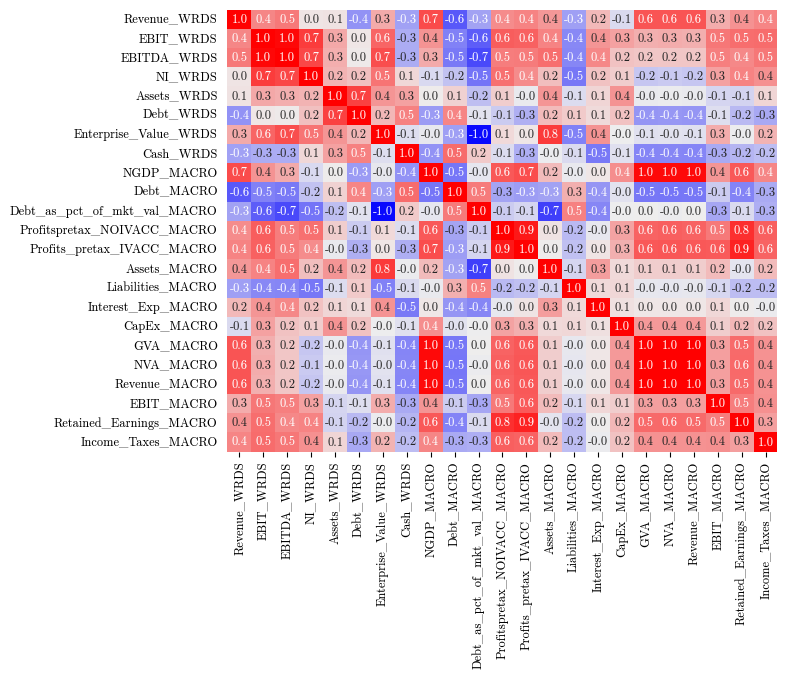

,Sum of Correlations
Revenue_WRDS,5.416206
EBIT_WRDS,7.374840
EBITDA_WRDS,6.488471
NI_WRDS,4.391636
Assets_WRDS,3.952836
Debt_WRDS,0.852404
Enterprise_Value_WRDS,3.400984
Cash_WRDS,-1.812019
NGDP_MACRO,7.190891
Debt_MACRO,-3.500015


In [46]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#0000FF', '#EEEEEE', '#FF0000']
th = [0, 0.5, 1]


data_correlation = rmdf.corr()


cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

fig, ax = plt.subplots(figsize=(11, 6.5))
plt.subplots_adjust(left=0.3, right=0.8, top=0.98, bottom=0.30)

ax = sns.heatmap(data_correlation, vmin=-1, vmax=1, cmap=cm, annot=True, fmt='.1f'.lstrip('0'), cbar=False, annot_kws={"size":9})
ax.set_xticklabels(list(data_correlation.columns), fontsize=9)
ax.set_yticks(np.linspace(0,len(data_correlation.columns)-1, len(data_correlation.columns))+0.5)
ax.set_yticklabels(list(data_correlation.columns), fontsize=9, verticalalignment='center')

plt.show()

display(pd.DataFrame(data_correlation.sum(), columns=['Sum of Correlations']))

In [49]:
data_correlation_ps

,Revenue_WRDS,EBIT_WRDS,EBITDA_WRDS,NI_WRDS,Assets_WRDS,Debt_WRDS,Enterprise_Value_WRDS,Cash_WRDS,NGDP_MACRO,Debt_MACRO,...,Assets_MACRO,Liabilities_MACRO,Interest_Exp_MACRO,CapEx_MACRO,GVA_MACRO,NVA_MACRO,Revenue_MACRO,EBIT_MACRO,Retained_Earnings_MACRO,Income_Taxes_MACRO
Assets_MACRO,0.0169,0.0025,0.0002,0.1976,0.0137,0.1662,0.0,0.9516,0.1714,0.041,...,0.0,0.515,0.0274,0.5778,0.3937,0.3887,0.3937,0.1736,0.8001,0.173
Assets_WRDS,0.7449,0.06,0.0823,0.1163,0.0,0.0,0.0133,0.034,0.9354,0.4424,...,0.0137,0.638,0.5095,0.0114,0.9196,0.9335,0.9196,0.5036,0.4627,0.5017
CapEx_MACRO,0.6046,0.034,0.2388,0.378,0.0114,0.2317,0.9794,0.7037,0.0074,0.763,...,0.5778,0.5225,0.7097,0.0,0.0195,0.0192,0.0195,0.3868,0.1313,0.235
Cash_WRDS,0.0341,0.0725,0.0713,0.527,0.034,0.0023,0.6576,0.0,0.01,0.0002,...,0.9516,0.5899,0.0008,0.7037,0.0028,0.0034,0.0028,0.0623,0.1222,0.1885
Debt_MACRO,0.0,0.002,0.0009,0.2482,0.4424,0.0028,0.0291,0.0002,0.0005,0.0,...,0.041,0.0921,0.0139,0.763,0.0007,0.0006,0.0007,0.3579,0.0026,0.0658
Debt_WRDS,0.01,0.8293,0.9096,0.2188,0.0,0.0,0.1379,0.0023,0.0229,0.0028,...,0.1662,0.3408,0.595,0.2317,0.0143,0.0157,0.0143,0.6804,0.1566,0.0578
Debt_as_pct_of_mkt_val_MACRO,0.038,0.0,0.0,0.0004,0.202,0.748,0.0,0.3322,0.8185,0.001,...,0.0,0.002,0.0036,0.9804,0.989,0.9529,0.989,0.0526,0.615,0.0783
EBITDA_WRDS,0.0008,0.0,0.0,0.0,0.0823,0.9096,0.0,0.0713,0.0675,0.0009,...,0.0002,0.004,0.0043,0.2388,0.2926,0.2726,0.2926,0.0018,0.0042,0.0008
EBIT_MACRO,0.0701,0.0007,0.0018,0.036,0.5036,0.6804,0.0709,0.0623,0.0135,0.3579,...,0.1736,0.5316,0.5314,0.3868,0.0314,0.0289,0.0314,0.0,0.0015,0.0094
EBIT_WRDS,0.0038,0.0,0.0,0.0,0.06,0.8293,0.0001,0.0725,0.0131,0.002,...,0.0025,0.0043,0.0133,0.034,0.0867,0.0749,0.0867,0.0007,0.0002,0.0002


C:\Users\jdsch\AppData\Local\Temp\ipykernel_24360\1419496179.py:85: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)


TypeError: Image data of dtype object cannot be converted to float

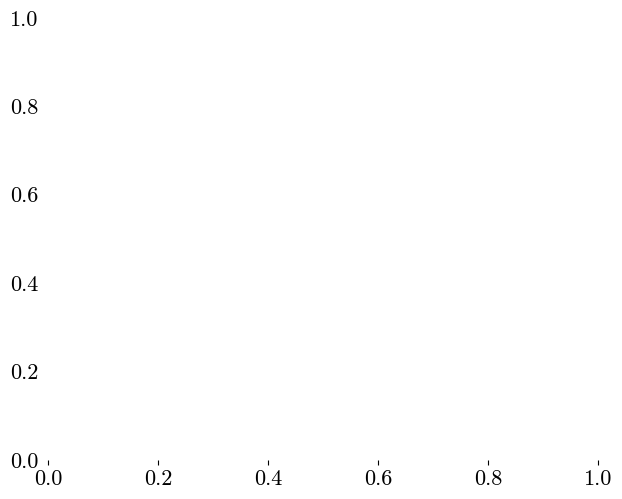

In [48]:
data_correlation_ps = calculate_pvalues(rmdf)

cdict = NonLinCdict(th, hc)
cm = matplotlib.colors.LinearSegmentedColormap('test', cdict)

fig, ax = plt.subplots(figsize=(11, 6.5))
plt.subplots_adjust(left=0.3, right=0.8, top=0.98, bottom=0.30)

ax = sns.heatmap(data_correlation_ps, vmin=-1, vmax=1, cmap=cm, annot=True, fmt='.1f'.lstrip('0'), cbar=False, annot_kws={"size":9})
ax.set_xticklabels(list(data_correlation_ps.columns), fontsize=9)
ax.set_yticks(np.linspace(0,len(data_correlation_ps.columns)-1, len(data_correlation_ps.columns))+0.5)
ax.set_yticklabels(list(data_correlation_ps.columns), fontsize=9, verticalalignment='center')

plt.show()

## Regressions

In [51]:
var = 'NGDP_MACRO'  # To test against WRDS revenue

revmod = smf.ols('Revenue_WRDS ~ ' + var, data=rmdf).fit()
display(revmod.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Revenue_WRDS   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     35.48
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           4.99e-07
Time:                        23:27:50   Log-Likelihood:                 82.631
No. Observations:                  43   AIC:                            -161.3
Df Residuals:                      41   BIC:                            -157.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0089      0.006     -1.377      0.176      -0.022       0.004
NGDP_MACRO     1.6537      0.278      5.956      0.000       1.093       2.214
==============================================================================
Omnibus:                        4.310   Durbin-Watson:                   2.751
Prob(Omnibus):                  0.116   Jarque-Bera (JB):                3.117
Skew:                          -0.607   Prob(JB):                        0.210
Kurtosis:                       3.515   Cond. No.                         50.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
naive_agg.Revenue / fdf.NGDP

datacqtr
2012-01-01    1.560567
2012-04-01    1.625756
2012-07-01    1.528160
2012-10-01    1.798931
2013-01-01    1.481864
2013-04-01    1.624075
2013-07-01    1.506132
2013-10-01    1.717178
2014-01-01    1.503593
2014-04-01    1.622987
2014-07-01    1.404005
2014-10-01    1.528778
2015-01-01    1.305116
2015-04-01    1.416555
2015-07-01    1.253675
2015-10-01    1.355247
2016-01-01    1.194542
2016-04-01    1.341919
2016-07-01    1.227174
2016-10-01    1.333060
2017-01-01    1.230703
2017-04-01    1.385605
2017-07-01    1.256853
2017-10-01    1.474200
2018-01-01    1.267839
2018-04-01    1.374813
2018-07-01    1.253397
2018-10-01    1.406141
2019-01-01    1.218252
2019-04-01    1.373123
2019-07-01    1.187228
2019-10-01    1.422520
2020-01-01    1.114405
2020-04-01    1.207814
2020-07-01    1.153678
2020-10-01    1.396820
2021-01-01    1.176271
2021-04-01    1.358753
2021-07-01    1.215611
2021-10-01    1.419509
2022-01-01    1.223775
2022-04-01    1.321006
2022-07-01    1.191223
20

In [62]:
list(tdfs)

['gvkey',
 'datadate',
 'fyearq',
 'fqtr',
 'indfmt',
 'consol',
 'popsrc',
 'datafmt',
 'tic',
 'cusip',
 'conm',
 'curcdq',
 'datacqtr',
 'datafqtr',
 'actq',
 'atq',
 'ceqq',
 'chq',
 'cshfdq',
 'cshoq',
 'cshprq',
 'dlcq',
 'dlttq',
 'dpactq',
 'dpq',
 'icaptq',
 'lctq',
 'niq',
 'oiadpq',
 'oibdpq',
 'piq',
 'revtq',
 'teqq',
 'txtq',
 'xintq',
 'xrdq',
 'dvy',
 'cik',
 'costat',
 'mkvaltq',
 'prccq',
 'ggroup',
 'gind',
 'gsector',
 'gsubind',
 'naics',
 'sic',
 'tid',
 'qid',
 'beta',
 'alpha',
 'beta_se',
 'alpha_se',
 'r2',
 'DGS1',
 'rfr',
 'Market_Cap',
 'Cash',
 'Debt',
 'Net_Debt',
 'Long_Term_Debt',
 'Enterprise_Value',
 'Current_Assets',
 'Current_Liabilities',
 'Current_Liabilities_minus_ST_Debt',
 'Current_Ratio',
 'Percent_Debt',
 'Common_Equity',
 'NI',
 'Pretax_Income',
 'EBIT',
 'EBITDA',
 'Taxes',
 'Tax_Rate',
 'Revenue',
 'NOPAT',
 'Total_Costs',
 'Total_Costs_inc_t',
 'RnD',
 'Assets',
 'Invested_Capital',
 'tobins_q',
 'EBIT_margin',
 'ROIC',
 'ROA',
 'ROE',
 '

In [66]:
tdfs.sort_values('Revenue', ascending=False)[['tic','conm','Revenue','datadate']].head(60)

,tic,conm,Revenue,datadate
140756_2011Q4,SNPMF,CHINA PETROLEUM & CHEMICAL,207307.334,2011-12-31
007471_1995Q1,MITSY,MITSUI & CO LTD,195805.000,1995-03-31
140756_2011Q2,SNPMF,CHINA PETROLEUM & CHEMICAL,190805.601,2011-06-30
011259_2022Q4,WMT,WALMART INC,164048.000,2023-01-31
007471_1996Q1,MITSY,MITSUI & CO LTD,163740.000,1996-03-31
011259_2023Q2,WMT,WALMART INC,161632.000,2023-07-31
011259_2023Q3,WMT,WALMART INC,160804.000,2023-10-31
011259_2021Q4,WMT,WALMART INC,152871.000,2022-01-31
011259_2022Q2,WMT,WALMART INC,152859.000,2022-07-31
011259_2022Q3,WMT,WALMART INC,152813.000,2022-10-31


End of Notebook.